### Calculate condition specificity, annotate cluster size

In [73]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import time
import sys
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
import matplotlib as mpl

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 150)
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [45]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_de_obs = adata_de.obs.copy()
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)
de_summary_stats = pd.read_csv('../../metadata/suppl_tables/DE_stats.suppl_table.csv', index_col=0)
downstream_gene_df = pd.read_csv('../../metadata/suppl_tables/clustering_downstream_genes.csv.gz', index_col=0)
cluster_nde75_ntotal50 = pd.read_csv('../../metadata/clustering_results.csv', index_col=0)

### Calculate the correlation mean of rest, stim8hr, stim48hr, and across condition (shared) for each cluster

In [46]:
def corr_mean_by_condition(df):
    df = df.reset_index()
    df = df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    corr_shared = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value
    
    return np.mean(corr_rest), np.mean(corr_stim8hr), np.mean(corr_stim48hr), np.mean(corr_shared)

In [50]:
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
# Get rid of -1 hdbscan (unclustered)
cluster_df = cluster_df[cluster_df.index!=-1].copy()
cluster_df.columns = ['cluster_gene_size']
cluster_df['corr_rest'] = 0
cluster_df['corr_stim8hr'] = 0
cluster_df['corr_stim48hr'] = 0
cluster_df['corr_shared'] = 0

In [51]:
for cl in cluster_df.index.unique():
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de_obs[adata_de_obs['target_contrast_corrected'].isin(gene_id_list)].index
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()

    cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)

cluster_df['corr_max'] = cluster_df.iloc[:,1:4].max(1)
cluster_df['corr_std'] = cluster_df.iloc[:,1:4].std(1) 
cluster_df['corr_cov'] = cluster_df.iloc[:,1:4].std(1) / cluster_df.iloc[:,1:4].mean(1)
cluster_df['corr_min'] = cluster_df.iloc[:,1:4].min(1)
cluster_df['corr_mean'] = cluster_df.iloc[:,1:4].mean(1)
cluster_df.sort_index(axis=0, ascending=True, inplace=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_26847/2492319127.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3874616734625326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_26847/2492319127.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0874579371430095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_26847/2492319127.py:6: FutureWarning: Setting an item of incompatible

### Classify clusters

In [52]:
corr_cov_thres = 0.5

In [53]:
cluster_df.loc[cluster_df.corr_cov<=corr_cov_thres,'condition_specificity'] = 'across_condition'

In [54]:
corr_fc_thres = 1.2
corr_thres = 0.2

def get_condition_specificity(row):
    # Calculate ratios
    r_rest = row['corr_rest'] / row['corr_mean']
    r_stim8hr = row['corr_stim8hr'] / row['corr_mean']
    r_stim48hr = row['corr_stim48hr'] / row['corr_mean']
    
    # Check pairs first (priority over singles)
    if ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)):
        return 'Rest_Stim8hr'
    elif ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Rest_Stim48hr'
    elif ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Stim8hr_Stim48hr'
        
    # Check singles
    elif r_rest > corr_fc_thres:
        return 'Rest'
    elif r_stim8hr > corr_fc_thres:
        return 'Stim8hr'
    elif r_stim48hr > corr_fc_thres:
        return 'Stim48hr'
        
    # Fallback (if no condition met)
    return 'across_condition'

# 1. Filter for high covariance
mask_cov = cluster_df['corr_cov'] > 0.5
filtered_df = cluster_df[mask_cov].copy()

# 2. Apply logic only to filtered rows
filtered_df['condition_specificity'] = filtered_df.apply(get_condition_specificity, axis=1)

# Update original dataframe
cluster_df.update(filtered_df)

In [55]:
cluster_df.to_csv('./results/clustering_condition_specificity.csv')

### Plot clusters with more than 3 unique genes

In [57]:
cluster_df = pd.read_csv('./results/clustering_condition_specificity.csv', index_col=0)

In [ ]:
cluster_df

In [59]:
mask = cluster_df.cluster_gene_size>3
cluster_df_filtered = cluster_df[mask].copy()

custom_order = ['Rest', 'Rest_Stim8hr', 'Stim8hr', 'Stim8hr_Stim48hr', 'Stim48hr', 'across_condition']
cluster_df_filtered['condition_specificity'] = pd.Categorical(
    cluster_df_filtered['condition_specificity'],
    categories=custom_order,
    ordered=True
)
cluster_df_filtered = cluster_df_filtered.sort_values(by='condition_specificity')

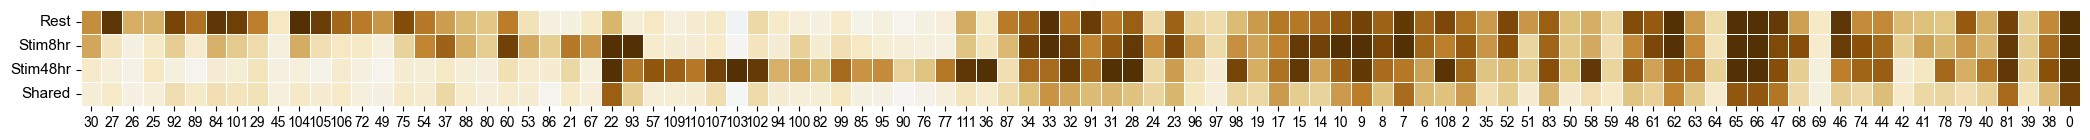

In [60]:
thres = 0.4
fig, ax = plt.subplots(figsize=(21, 1.5))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(cluster_df_filtered.loc[:,['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, 
            yticklabels=['Rest', 'Stim8hr', 'Stim48hr', 'Shared'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr', 'Shared'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_df_filtered.index.tolist(), fontsize=10, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/cluster_ngene>3_withlabel.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Selected cluster for the main figure

In [61]:
mask = ((cluster_df.cluster_gene_size>=55)&(cluster_df.corr_max>0.2))|\
((cluster_df.cluster_gene_size<55)&(cluster_df.cluster_gene_size>6)&(cluster_df.corr_max>0.3))|\
((cluster_df.cluster_gene_size==4)&(cluster_df.corr_max>0.375))|\
((cluster_df.cluster_gene_size==6)&(cluster_df.corr_max>0.32))
cluster_df_selected = cluster_df[mask].copy()
cluster_df_selected = cluster_df_selected.sort_index()

In [62]:
cluster_order = [106, 27, 105, 101, 84, 104, 30, 60,
                 21, 22, 99, 93, 
                 103, 36, 77, 107, 102, 111,
                 7, 62,
                 98, 46, 91, 33, 108, 61, 31, 32, 15, 28, 58,
                 68, 48, 74, 38,
                 34, 8, 2, 83, 9, 10, 0, 65, 66, 81]

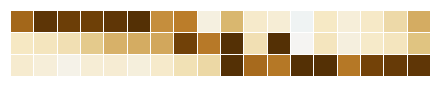

In [63]:
thres = 0.4
fig, ax = plt.subplots(figsize=(4.5, 0.96))
sns.heatmap(cluster_df_selected.loc[cluster_order[:18], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condspec_withoutshared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

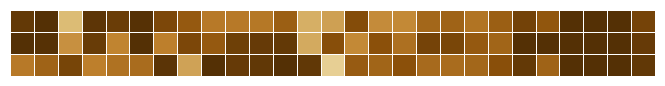

In [64]:
thres = 0.4
fig, ax = plt.subplots(figsize=(6.75, 0.96))
sns.heatmap(cluster_df_selected.loc[cluster_order[18:], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condacross_withoutshared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

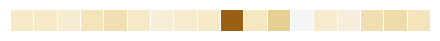

In [65]:
thres = 0.4
fig, ax = plt.subplots(figsize=(4.5, 0.52))
sns.heatmap(cluster_df_selected.loc[cluster_order[:18], ['corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condspec_shared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

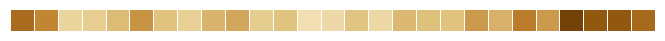

In [66]:
thres = 0.4
fig, ax = plt.subplots(figsize=(6.75, 0.52))
sns.heatmap(cluster_df_selected.loc[cluster_order[18:], ['corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condacross_shared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

## Check regulator expression across clusters

In [67]:
cluster_df = pd.read_csv('./results/clustering_condition_specificity.csv', index_col=0)
mask = cluster_df.cluster_gene_size>3
cluster_df_filtered = cluster_df[mask].copy()

custom_order = ['Rest', 'Rest_Stim8hr', 'Stim8hr', 'Stim8hr_Stim48hr', 'Stim48hr', 'across_condition']
cluster_df_filtered['condition_specificity'] = pd.Categorical(
    cluster_df_filtered['condition_specificity'],
    categories=custom_order,
    ordered=True
)
cluster_df_filtered = cluster_df_filtered.sort_values(by='condition_specificity')

In [68]:
all_gene = set(de_summary_stats[de_summary_stats['culture_condition']=='Rest']['target_contrast']) \
& set(de_summary_stats[de_summary_stats['culture_condition']=='Stim8hr']['target_contrast']) \
& set(de_summary_stats[de_summary_stats['culture_condition']=='Stim48hr']['target_contrast'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats['culture_condition']=='Rest'].set_index('target_contrast').loc[all_gene]['target_baseMean']
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats['culture_condition']=='Stim8hr'].set_index('target_contrast').loc[all_gene]['target_baseMean']
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats['culture_condition']=='Stim48hr'].set_index('target_contrast').loc[all_gene]['target_baseMean']

df = all_gene_baseMean_df.dropna()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

In [69]:
df_exp = pd.DataFrame(index=cluster_nde75_ntotal50['hdbscan'].unique().tolist())
for cl in cluster_nde75_ntotal50['hdbscan'].unique():
    # For each cluster, get regulator member list
    regulator = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats['culture_condition']=='Rest'].set_index('target_contrast').loc[regulator]['target_baseMean']
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats['culture_condition']=='Stim8hr'].set_index('target_contrast').loc[regulator]['target_baseMean']
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats['culture_condition']=='Stim48hr'].set_index('target_contrast').loc[regulator]['target_baseMean']

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3
df_exp['regulator_stim8_rest_diff'] = df_exp['regulator_stim8_rest_diff'].fillna(0)
df_exp['regulator_stim48_rest_diff'] = df_exp['regulator_stim48_rest_diff'].fillna(0)
df_exp['regulator_stim48_stim8_diff'] = df_exp['regulator_stim48_stim8_diff'].fillna(0)
df_exp['regulator_stim8_rest_p'] = df_exp['regulator_stim8_rest_p'].fillna(1)
df_exp['regulator_stim48_rest_p'] = df_exp['regulator_stim48_rest_p'].fillna(1)
df_exp['regulator_stim48_stim8_p'] = df_exp['regulator_stim48_stim8_p'].fillna(1)

# Multiple test correction
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [71]:
cluster_order = cluster_df_filtered.index.tolist()

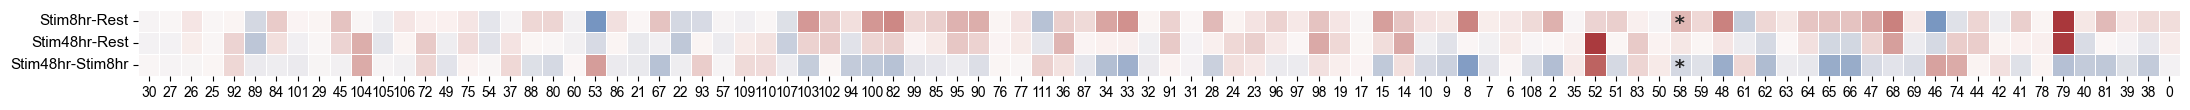

In [74]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).map(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(22, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T,
            vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=10, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/regulator_exp_by_cluster.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

#### Plot colormap

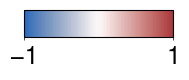

In [14]:
thres = 1
orientation = 'bottom'
colormap = 'vlag'
cmap = sns.color_palette(colormap, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 0.9))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-thres, thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres)+orientation+'_'+colormap+'.png', dpi=600, bbox_inches='tight', pad_inches=0)